# Working Notebook 1

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LassoLars, TweedieRegressor

import env

# Acquire data

In [2]:
def get_zillow_data():
        ''' Acquire Zillow data using properties_2017 table from Code up Data Base. Columns bedroomcnt, 
            bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips 
        '''
   
         # sql query for acquisition
        sql_query = """
        SELECT calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt,yearbuilt, fireplacecnt,
        decktypeid, poolcnt, garagecarcnt,fips

        FROM properties_2017
        LEFT JOIN propertylandusetype USING(propertylandusetypeid)
        LEFT JOIN predictions_2017 USING(parcelid)
        WHERE (propertylandusetype.propertylandusedesc LIKE ('%%Single%%')) 
            AND (predictions_2017.transactiondate like '2017%%');
        """
        # Acquisition
        df = pd.read_sql(sql_query, env.get_connection('zillow'))
        return df

In [3]:
# had to adress % by using %% so it could be read by notebook

In [4]:
# import data
df = get_zillow_data()

In [5]:
# 52441 observations
df.shape

(52441, 10)

In [6]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  52359 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   bedroomcnt                    52441 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   yearbuilt                     52325 non-null  float64
 5   fireplacecnt                  7243 non-null   float64
 6   decktypeid                    389 non-null    float64
 7   poolcnt                       11096 non-null  float64
 8   garagecarcnt                  18015 non-null  float64
 9   fips                          52441 non-null  float64
dtypes: float64(10)
memory usage: 4.0 MB


In [7]:
df.isnull().sum().sort_values()

bathroomcnt                         0
bedroomcnt                          0
fips                                0
taxvaluedollarcnt                   1
calculatedfinishedsquarefeet       82
yearbuilt                         116
garagecarcnt                    34426
poolcnt                         41345
fireplacecnt                    45198
decktypeid                      52052
dtype: int64

<div class="alert alert-info"> 
roomcnt                          0
    
fips                             0
    
regionidcounty                   0
    
latitude                         0
    
propertycountylandusecode        0
    
longitude                        0
    
regionidzip                     26
    
yearbuilt                      116
    
fullbathcnt                    137
    
calculatedbathnbr              137

I could maybe add one of these to explorations
    

In [8]:
df.dtypes

calculatedfinishedsquarefeet    float64
bathroomcnt                     float64
bedroomcnt                      float64
taxvaluedollarcnt               float64
yearbuilt                       float64
fireplacecnt                    float64
decktypeid                      float64
poolcnt                         float64
garagecarcnt                    float64
fips                            float64
dtype: object

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calculatedfinishedsquarefeet,52359.0,1922.890754,1004.365838,128.0,1268.0,1659.0,2306.00,21929.0
bathroomcnt,52441.0,2.299403,1.022772,0.0,2.0,2.0,3.00,18.0
bedroomcnt,52441.0,3.300681,0.949094,0.0,3.0,3.0,4.00,14.0
taxvaluedollarcnt,52440.0,529688.163921,751894.553363,1000.0,193747.5,373612.0,619301.25,49061236.0
yearbuilt,52325.0,1963.393884,23.133571,1878.0,1950.0,1961.0,1979.00,2016.0
fireplacecnt,7243.0,1.209858,0.512885,1.0,1.0,1.0,1.00,5.0
decktypeid,389.0,66.000000,0.000000,66.0,66.0,66.0,66.00,66.0
poolcnt,11096.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
garagecarcnt,18015.0,1.948987,0.549944,0.0,2.0,2.0,2.00,14.0
fips,52441.0,6049.132149,21.029067,6037.0,6037.0,6037.0,6059.00,6111.0


<div class="alert alert-info"> There seems to be bathrooms/ bedrooms with min of 0 and max above what ight be consider a single family dweling

In [10]:
# rename columns
df = df.rename(columns={'bedroomcnt': 'bedrooms','bathroomcnt': 'bathrooms',
            'calculatedfinishedsquarefeet': 'squarefeet','taxvaluedollarcnt': 'home_value',
                        'lotsizesquarefeet':'lot','fireplacecnt': 'fireplace','decktypeid':'deck','poolcnt':'pool',
                       'garagecarcnt':'garage','fips':'county'})

In [11]:
def process_fancy_features(df, feature):
    df[feature]=df[feature].replace(r"^\s*$", np.nan, regex=True)
    if df[feature]:
        df[feature] == 1
    else:
        df[feature].fillna(0)
    return df[feature].isnull().sum()

In [12]:
df.garage 

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
52436   NaN
52437   NaN
52438   NaN
52439   NaN
52440   NaN
Name: garage, Length: 52441, dtype: float64

In [13]:
df.isnull().sum()

squarefeet       82
bathrooms         0
bedrooms          0
home_value        1
yearbuilt       116
fireplace     45198
deck          52052
pool          41345
garage        34426
county            0
dtype: int64

In [14]:
fancy_features = ['fireplace','deck','pool','garage']

In [15]:
def process_fancy_features(df, feature):
    df[feature]=df[feature].replace(r"^\s*$", np.nan, regex=True)     
    # fill fancy features with 0 assumption that if it was not mark it did not exist
    df[feature] = df[feature].fillna(0)
    return df

In [16]:
for i in fancy_features:
    process_fancy_features(df, i)

These values were filled in with 0 since the presense was not anotated it is assumed it does not exist

fireplace     45198

deck          52052

pool          41345

garage        34426

In [17]:
# still have 82 nulls in square feet and 116 nulls in yearbuilt and 1 null in home_value
df.isnull().sum()

squarefeet     82
bathrooms       0
bedrooms        0
home_value      1
yearbuilt     116
fireplace       0
deck            0
pool            0
garage          0
county          0
dtype: int64

In [18]:
df.describe()

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,county
count,52359.000000,52441.000000,52441.000000,5.244000e+04,52325.000000,52441.000000,52441.000000,52441.00000,52441.000000,52441.000000
mean,1922.890754,2.299403,3.300681,5.296882e+05,1963.393884,0.167102,0.489579,0.21159,0.669533,6049.132149
std,1004.365838,1.022772,0.949094,7.518946e+05,23.133571,0.458887,5.663314,0.40844,0.980074,21.029067
min,128.000000,0.000000,0.000000,1.000000e+03,1878.000000,0.000000,0.000000,0.00000,0.000000,6037.000000
25%,1268.000000,2.000000,3.000000,1.937475e+05,1950.000000,0.000000,0.000000,0.00000,0.000000,6037.000000
50%,1659.000000,2.000000,3.000000,3.736120e+05,1961.000000,0.000000,0.000000,0.00000,0.000000,6037.000000
75%,2306.000000,3.000000,4.000000,6.193012e+05,1979.000000,0.000000,0.000000,0.00000,2.000000,6059.000000
max,21929.000000,18.000000,14.000000,4.906124e+07,2016.000000,5.000000,66.000000,1.00000,14.000000,6111.000000


## outliers

In [19]:
def handle_outliers(df):
    """Manually handle outliers '"""
    df = df[df.bathrooms <= 6]
    
    df = df[df.bedrooms <= 6]
    
    df = df[df.home_value <= 1_750_000]
    
    return df


In [20]:
df.shape

(52441, 10)

In [21]:
(51918-1632)/(52441)

0.9589061993478385

In [22]:
1632/ 52441

0.031120688011288877

In [23]:
# removed homes above 1_750_000 as outliers total of 1632 rows about 3% of data still retain .958 of original dat
df[df.home_value > 1_750_000]

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,county
55,3681.0,4.0,5.0,1850800.0,1993.0,0.0,0.0,1.0,2.0,6059.0
61,3407.0,4.0,4.0,2311622.0,2007.0,0.0,0.0,0.0,0.0,6037.0
120,1486.0,2.0,3.0,4080000.0,1952.0,0.0,0.0,0.0,0.0,6037.0
130,1482.0,2.0,2.0,3822146.0,1948.0,0.0,0.0,0.0,0.0,6037.0
145,7114.0,5.5,5.0,4073264.0,2007.0,0.0,0.0,1.0,3.0,6059.0
...,...,...,...,...,...,...,...,...,...,...
52279,3388.0,5.0,4.0,2329951.0,1976.0,0.0,0.0,1.0,0.0,6037.0
52332,3032.0,2.5,4.0,2202000.0,1964.0,0.0,0.0,1.0,2.0,6059.0
52375,5785.0,5.5,5.0,2649869.0,2004.0,0.0,0.0,1.0,2.0,6059.0
52418,6416.0,5.0,3.0,1933183.0,2003.0,0.0,0.0,1.0,0.0,6037.0


In [24]:
pd.options.display.float_format = '{:,.3f}'.format
df. home_value.describe()

count       52,440.000
mean       529,688.164
std        751,894.553
min          1,000.000
25%        193,747.500
50%        373,612.000
75%        619,301.250
max     49,061,236.000
Name: home_value, dtype: float64

In [25]:
52112/52441

0.9937262828702733

In [26]:
52112-52441

-329

In [27]:
df = handle_outliers(df)

# nulls and 0

In [28]:
df.isnull().sum()

squarefeet    53
bathrooms      0
bedrooms       0
home_value     0
yearbuilt     86
fireplace      0
deck           0
pool           0
garage         0
county         0
dtype: int64

In [29]:
df[df.squarefeet.isnull()]

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,county
1601,NaN,0.000,0.000,"830,145.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"
2714,NaN,0.000,0.000,"643,406.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"
4617,NaN,0.000,0.000,"375,218.000","1,932.000",0.000,0.000,0.000,0.000,"6,059.000"
5651,NaN,0.000,0.000,"178,684.000","1,955.000",0.000,0.000,0.000,0.000,"6,059.000"
6744,NaN,1.000,2.000,"488,078.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"
7379,NaN,0.000,0.000,"26,405.000",NaN,0.000,0.000,0.000,0.000,"6,037.000"
7527,NaN,0.000,0.000,"973,624.000",NaN,0.000,0.000,0.000,0.000,"6,037.000"
8503,NaN,0.000,0.000,"38,206.000",NaN,0.000,0.000,0.000,0.000,"6,037.000"
8583,NaN,0.000,0.000,"16,477.000",NaN,0.000,0.000,0.000,0.000,"6,111.000"
8947,NaN,0.000,0.000,"656,601.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"


In [30]:
# dropped properties with no bathrooms and no bedrooms 153 rows at still retained .990 of original data
df= df[~(df.bathrooms==0) & ~(df.bedrooms ==0)]

In [31]:
df.shape

(50326, 10)

In [32]:
51959 - 52112

-153

In [33]:
51959/52441

0.9908087183692149

In [34]:
df[df['squarefeet'].isnull()]

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,county
6744,NaN,1.000,2.000,"488,078.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"
10646,NaN,1.500,2.000,"719,590.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"
13966,NaN,1.000,2.000,"400,778.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"
16017,NaN,1.000,2.000,"107,267.000",NaN,1.000,0.000,0.000,0.000,"6,059.000"
18048,NaN,1.000,1.000,"390,087.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"
37961,NaN,4.500,5.000,"1,461,048.000","2,004.000",2.000,0.000,0.000,2.000,"6,111.000"
47975,NaN,1.000,1.000,"165,899.000",NaN,1.000,0.000,0.000,0.000,"6,059.000"
47995,NaN,1.000,1.000,"131,534.000",NaN,0.000,0.000,0.000,0.000,"6,059.000"


In [35]:
df.squarefeet.mean()

1830.7172582376088

In [36]:
df.isnull().sum()

squarefeet     8
bathrooms      0
bedrooms       0
home_value     0
yearbuilt     39
fireplace      0
deck           0
pool           0
garage         0
county         0
dtype: int64

In [37]:
# dropped null values in yearbuilt 89 and 1 in home_value still retained .99 of original data.
# total dropped 90, 
df = df.dropna()

In [38]:
df.shape

(50286, 10)

In [39]:
51918/52441

0.9900268873591274

### fireplace

In [40]:
df.fireplace.value_counts()

0.000    43244
1.000     5948
2.000      884
3.000      194
4.000       16
Name: fireplace, dtype: int64

In [41]:
df.fireplace = df.fireplace.replace({2:1, 3:1, 4:1, 5:1})
df.fireplace.value_counts()

0.000    43244
1.000     7042
Name: fireplace, dtype: int64

### garage

In [42]:
df.garage.value_counts()

0.000     32993
2.000     14430
1.000      2174
3.000       507
4.000       147
5.000        20
6.000         7
7.000         3
8.000         2
9.000         1
13.000        1
14.000        1
Name: garage, dtype: int64

In [43]:
df.garage = df.garage.replace({2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 13:1,14:1})
df.garage.value_counts()

0.000    32993
1.000    17293
Name: garage, dtype: int64

### pool

In [44]:
df.pool.value_counts()

0.000    40272
1.000    10014
Name: pool, dtype: int64

In [45]:
df.deck.value_counts()

0.000     49936
66.000      350
Name: deck, dtype: int64

In [46]:
df.deck= df.deck.replace({66:1})
df.deck.value_counts()

0.000    49936
1.000      350
Name: deck, dtype: int64

# New Column

In [47]:
#Creating new column for home age using year_built, casting as float
df['home_age'] = 2017- df['yearbuilt']
df["home_age"] = df["home_age"].astype('float')

In [48]:
df['fancy_features'] = (df.garage==1)|(df.deck == 1)|(df.pool == 1)|(df.fireplace == 1)

## FIPS

In [49]:
# Relabeling FIPS data
#df['fips'] = df.fips.replace({6037:'Los Angeles',
 #                  6059:'Orange',
  #                 6111:'Ventura'})

# split data for exploration

In [50]:
def split_data(df):
    '''
    split_data takes in data Frame and splits into  train , validate, test.
    The split is 20% test 80% train/validate. Then 30% of 80% validate and 70% of 80% train.
    Aproximately (train 56%, validate 24%, test 20%)
    Returns train, validate, and test 
    '''
    # split test data from train/validate
    train_and_validate, test = train_test_split(df, random_state=123, test_size=.2)

    # split train from validate
    train, validate = train_test_split(train_and_validate, random_state=123, test_size=.3)
                                   
    return train, validate, test

In [51]:
train, validate, test = split_data(df)

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28159 entries, 32899 to 52047
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   squarefeet      28159 non-null  float64
 1   bathrooms       28159 non-null  float64
 2   bedrooms        28159 non-null  float64
 3   home_value      28159 non-null  float64
 4   yearbuilt       28159 non-null  float64
 5   fireplace       28159 non-null  float64
 6   deck            28159 non-null  float64
 7   pool            28159 non-null  float64
 8   garage          28159 non-null  float64
 9   county          28159 non-null  float64
 10  home_age        28159 non-null  float64
 11  fancy_features  28159 non-null  bool   
dtypes: bool(1), float64(11)
memory usage: 2.6 MB


In [53]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
squarefeet,"28,159.000","1,832.226",803.293,300.000,"1,256.000","1,633.000","2,227.000","8,251.000"
bathrooms,"28,159.000",2.229,0.885,1.000,2.000,2.000,3.000,6.000
bedrooms,"28,159.000",3.273,0.887,1.000,3.000,3.000,4.000,6.000
home_value,"28,159.000","435,017.576","332,865.944","3,254.000","187,537.500","362,951.000","583,900.500","1,750,000.000"
yearbuilt,"28,159.000","1,963.119",22.664,"1,878.000","1,950.000","1,960.000","1,978.000","2,015.000"
fireplace,"28,159.000",0.141,0.348,0.000,0.000,0.000,0.000,1.000
deck,"28,159.000",0.007,0.083,0.000,0.000,0.000,0.000,1.000
pool,"28,159.000",0.204,0.403,0.000,0.000,0.000,0.000,1.000
garage,"28,159.000",0.344,0.475,0.000,0.000,0.000,1.000,1.000
county,"28,159.000","6,049.246",21.220,"6,037.000","6,037.000","6,037.000","6,059.000","6,111.000"


In [54]:
train.head()

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,county,home_age,fancy_features
32899,"1,026.000",1.000,2.000,"346,258.000","1,924.000",0.000,0.000,0.000,0.000,"6,037.000",93.000,False
4511,"1,728.000",2.000,3.000,"520,000.000","1,987.000",0.000,0.000,0.000,0.000,"6,037.000",30.000,False
29470,"1,840.000",2.000,4.000,"217,589.000","1,973.000",0.000,0.000,0.000,1.000,"6,059.000",44.000,True
15398,"2,581.000",3.000,4.000,"210,507.000","1,994.000",0.000,0.000,1.000,0.000,"6,037.000",23.000,True
14156,902.000,2.000,2.000,"294,263.000","1,950.000",0.000,0.000,0.000,0.000,"6,037.000",67.000,False


In [55]:
train.columns

Index(['squarefeet', 'bathrooms', 'bedrooms', 'home_value', 'yearbuilt',
       'fireplace', 'deck', 'pool', 'garage', 'county', 'home_age',
       'fancy_features'],
      dtype='object')

In [56]:
#sns.pairplot(train['squarefeet', 'bathrooms', 'bedrooms', 'home_value', 'yearbuilt',
  #      'county', 'home_age']
 #      )

In [57]:
# correaltion between variables
zillow_corr = train.corr(method='spearman')
zillow_corr

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,county,home_age,fancy_features
squarefeet,1.000,0.828,0.660,0.488,0.533,0.176,0.076,0.321,0.226,0.205,-0.533,0.347
bathrooms,0.828,1.000,0.623,0.445,0.595,0.141,0.069,0.277,0.227,0.205,-0.595,0.334
bedrooms,0.660,0.623,1.000,0.264,0.428,0.152,0.040,0.235,0.198,0.184,-0.428,0.274
home_value,0.488,0.445,0.264,1.000,0.267,0.127,0.067,0.218,0.207,0.197,-0.267,0.276
yearbuilt,0.533,0.595,0.428,0.267,1.000,0.242,0.073,0.124,0.422,0.409,-1.000,0.398
fireplace,0.176,0.141,0.152,0.127,0.242,1.000,0.175,0.070,0.550,0.613,-0.242,0.430
deck,0.076,0.069,0.040,0.067,0.073,0.175,1.000,0.019,0.109,0.157,-0.073,0.089
pool,0.321,0.277,0.235,0.218,0.124,0.070,0.019,1.000,0.045,0.034,-0.124,0.537
garage,0.226,0.227,0.198,0.207,0.422,0.550,0.109,0.045,1.000,0.965,-0.422,0.768
county,0.205,0.205,0.184,0.197,0.409,0.613,0.157,0.034,0.965,1.000,-0.409,0.743


<AxesSubplot:>

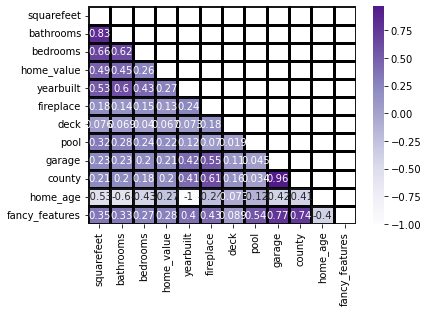

In [58]:
# pass my correlation matrix to Seaborn's heatmap 
kwargs = {'alpha':.9,
          'linewidth':3, 
          'linestyle':'-',
          'linecolor':'black'}
sns.heatmap(zillow_corr, cmap='Purples', annot=True, 
            mask=np.triu(zillow_corr), **kwargs)

In [59]:
train.columns.to_list()

['squarefeet',
 'bathrooms',
 'bedrooms',
 'home_value',
 'yearbuilt',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'county',
 'home_age',
 'fancy_features']

In [60]:
def plot_variable_pair(df):
    columns = ['squarefeet',
 'bathrooms',
 'bedrooms',
 'home_value',
 'yearbuilt',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'home_age',
    'county',
              'fancy_features']
    for i, col in enumerate(columns):
        sns.lmplot(data=df, x=col, y='home_value', line_kws={'color':'red'})
        plt.show()

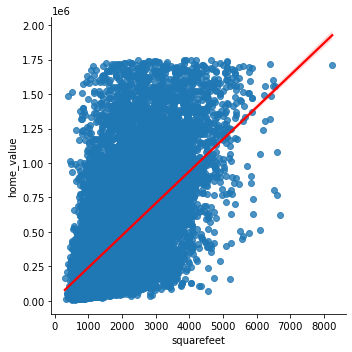

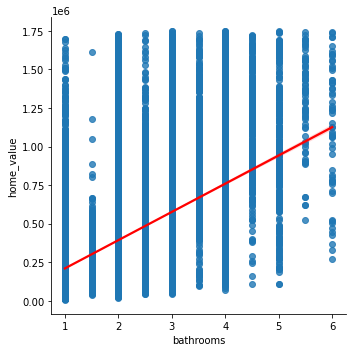

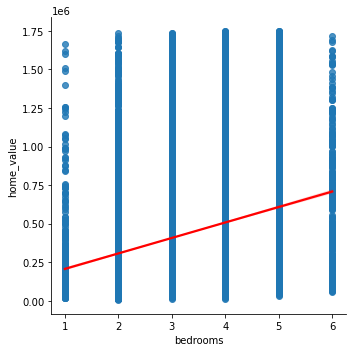

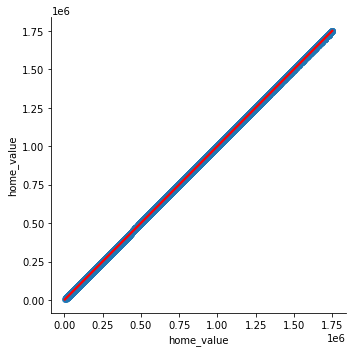

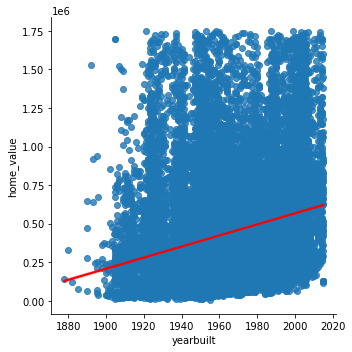

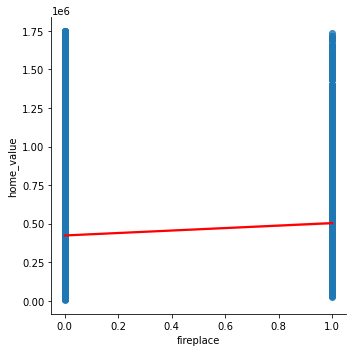

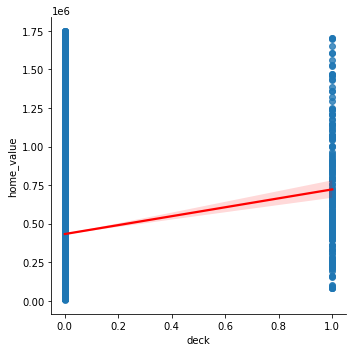

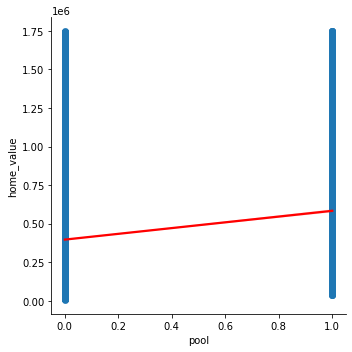

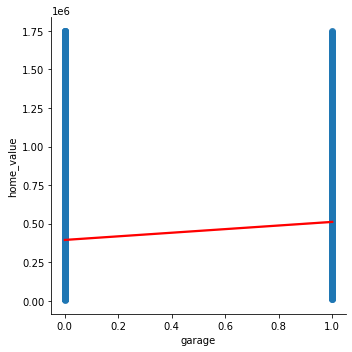

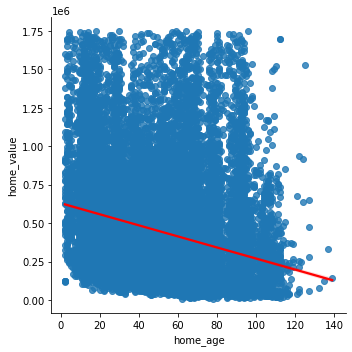

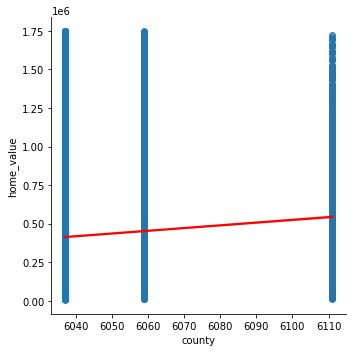

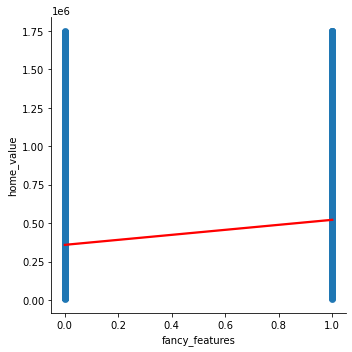

In [61]:
plot_variable_pair(train)

In [62]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            plt.show()

In [63]:
train.columns

Index(['squarefeet', 'bathrooms', 'bedrooms', 'home_value', 'yearbuilt',
       'fireplace', 'deck', 'pool', 'garage', 'county', 'home_age',
       'fancy_features'],
      dtype='object')

In [64]:
# set categories
cat_vars =['pool','garage','deck','fireplace', 'bathrooms', 'bedrooms','county','fancy_features']
cont_vars =['home_value','home_age','squarefeet']

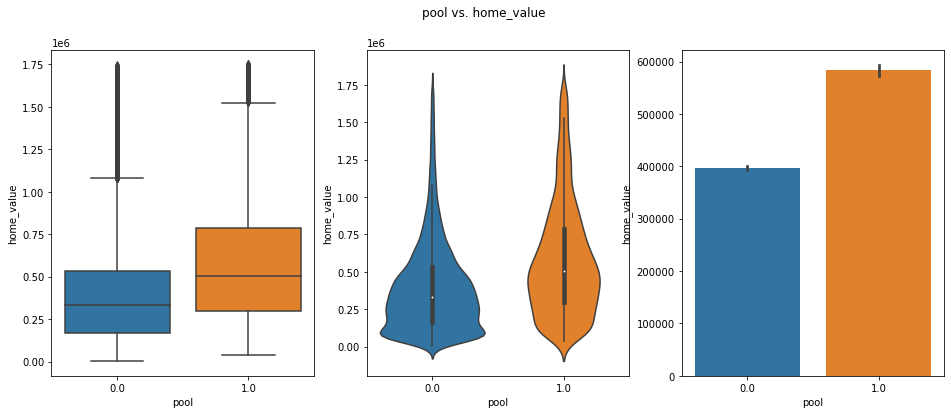

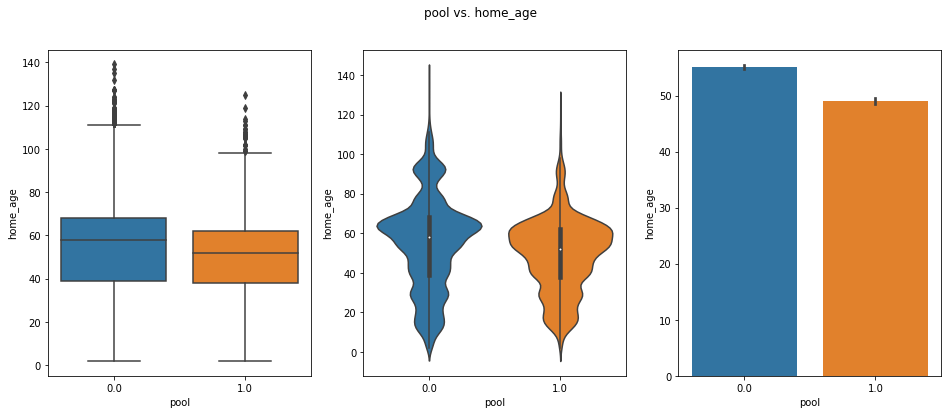

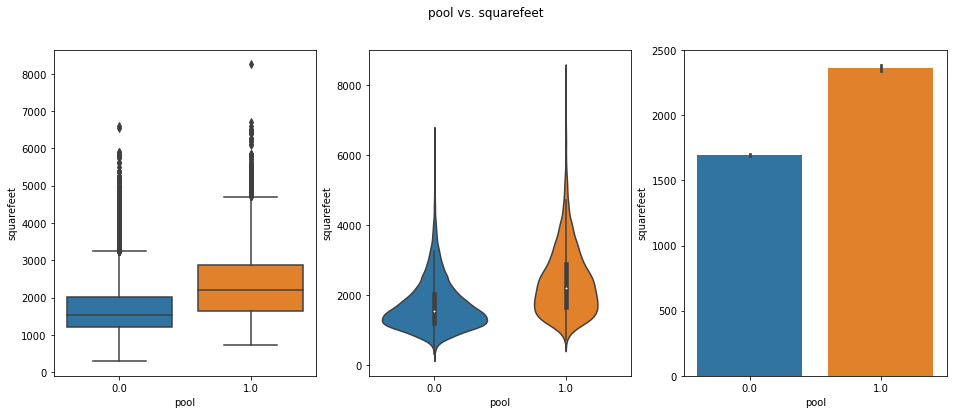

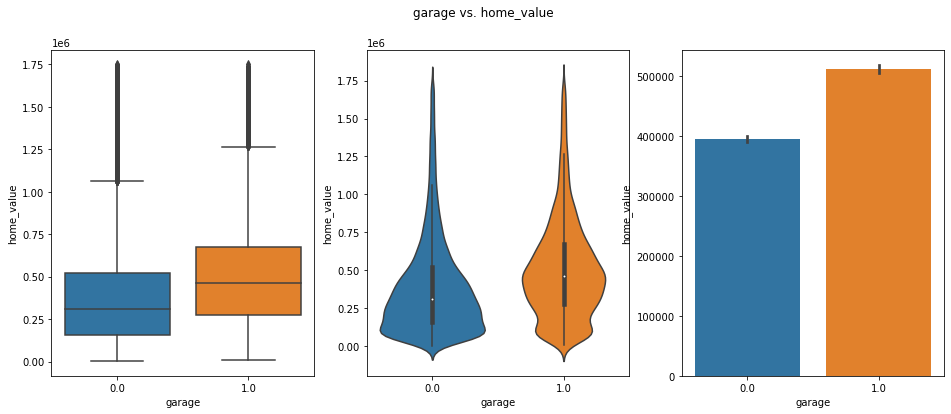

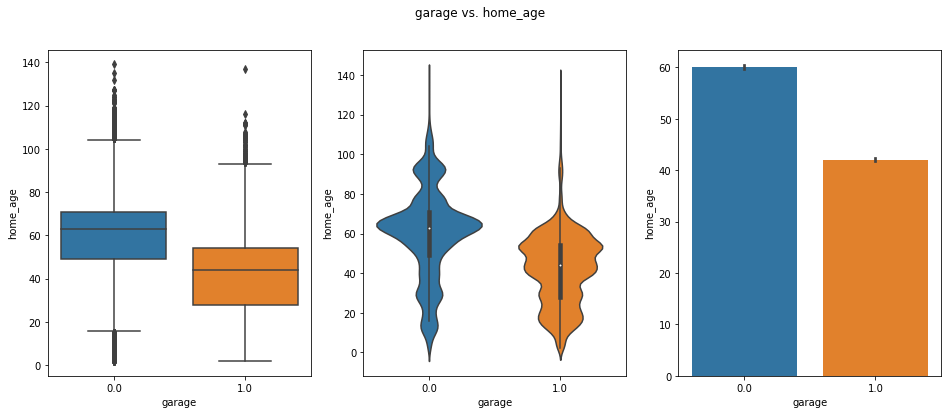

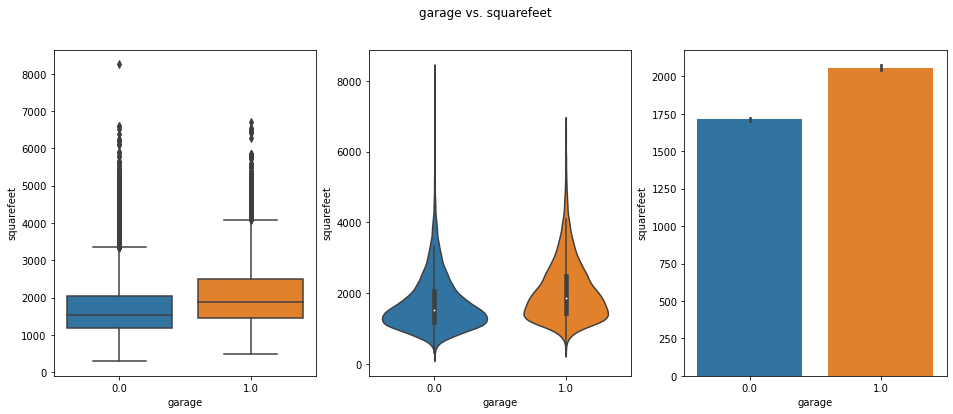

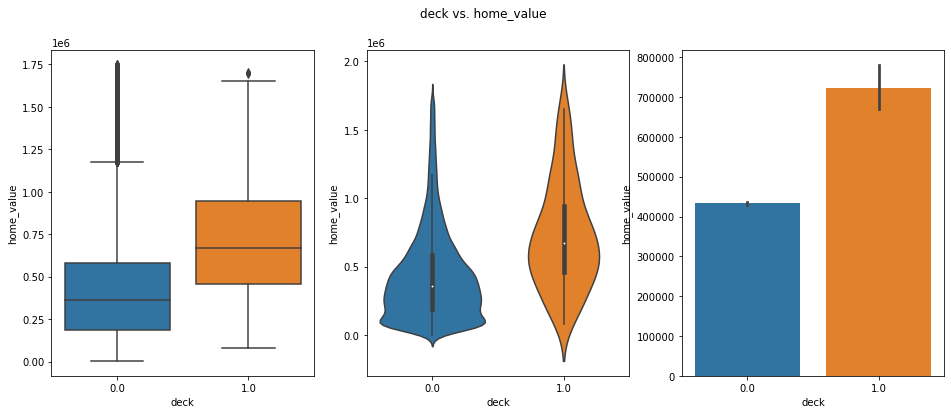

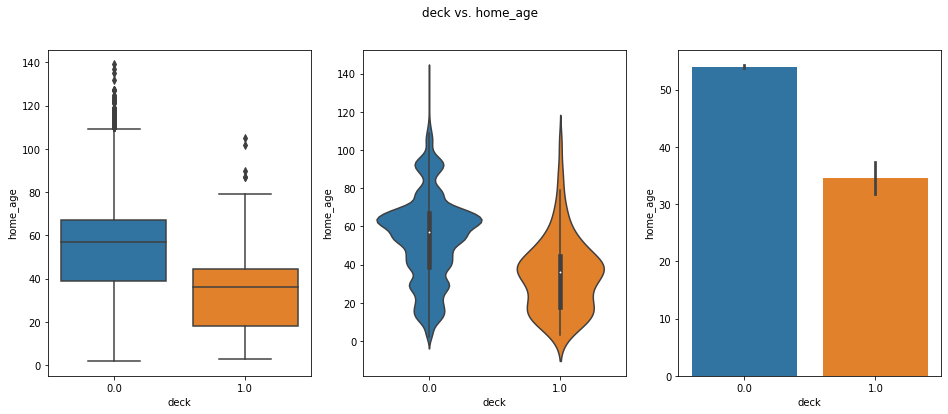

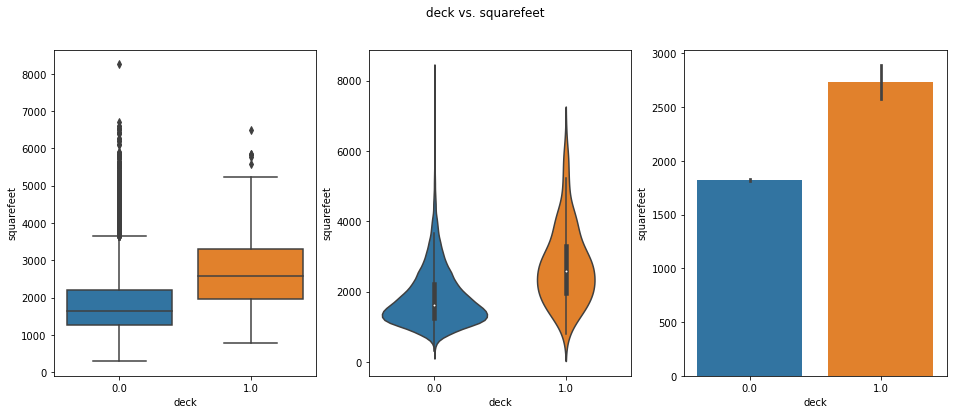

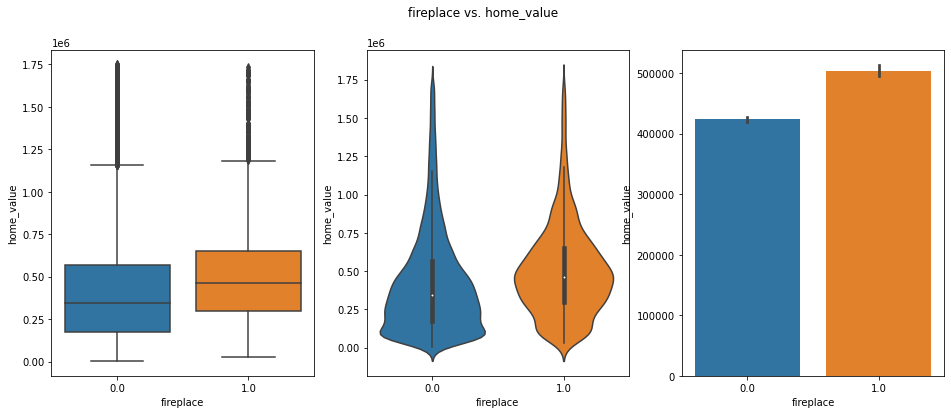

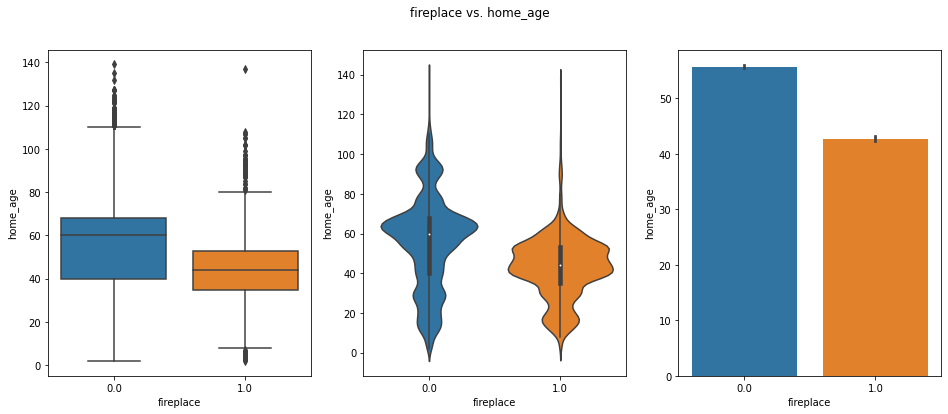

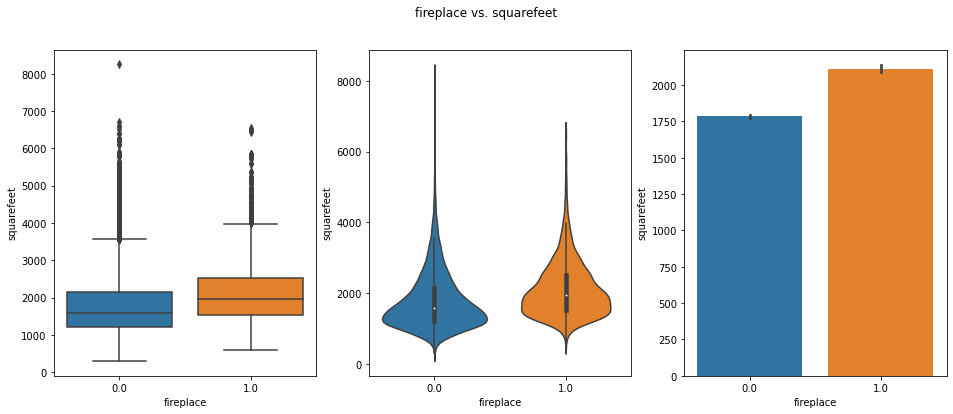

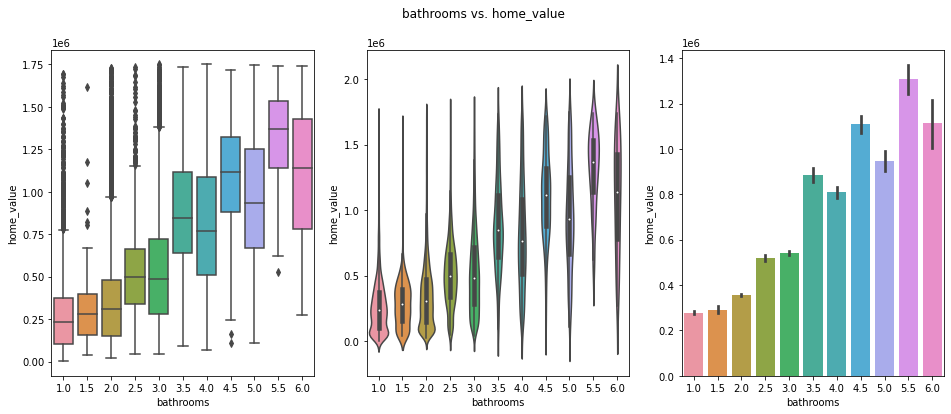

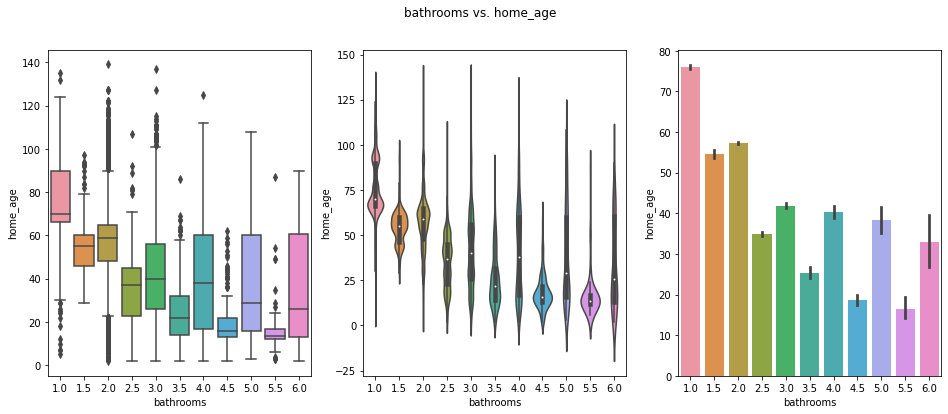

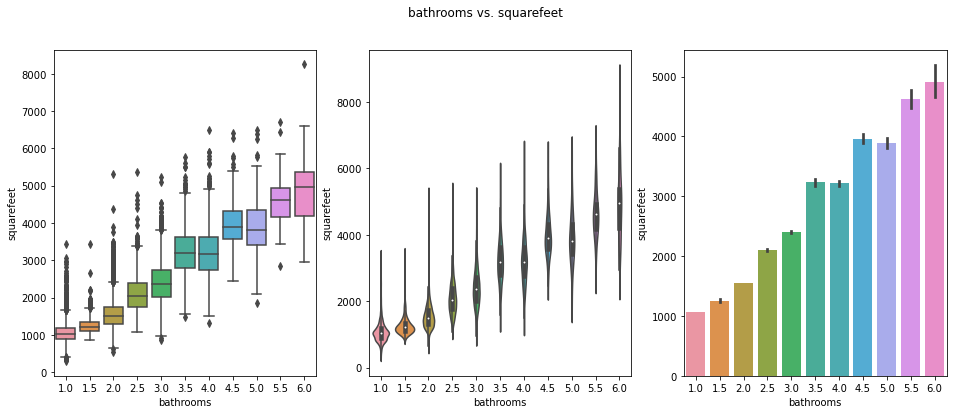

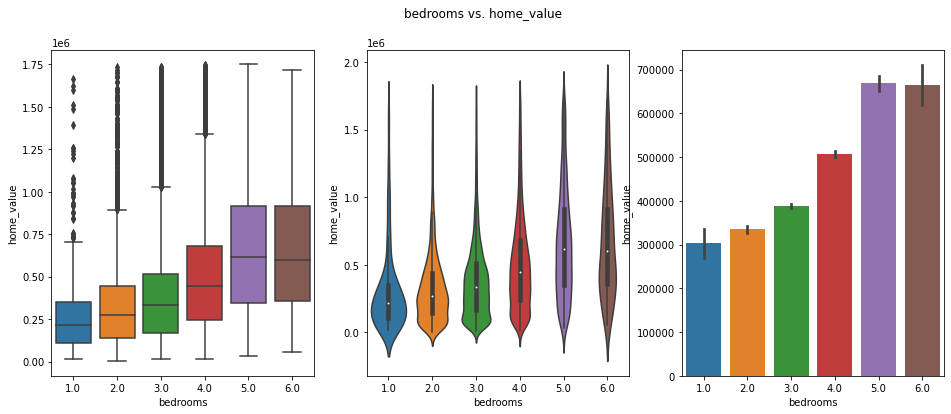

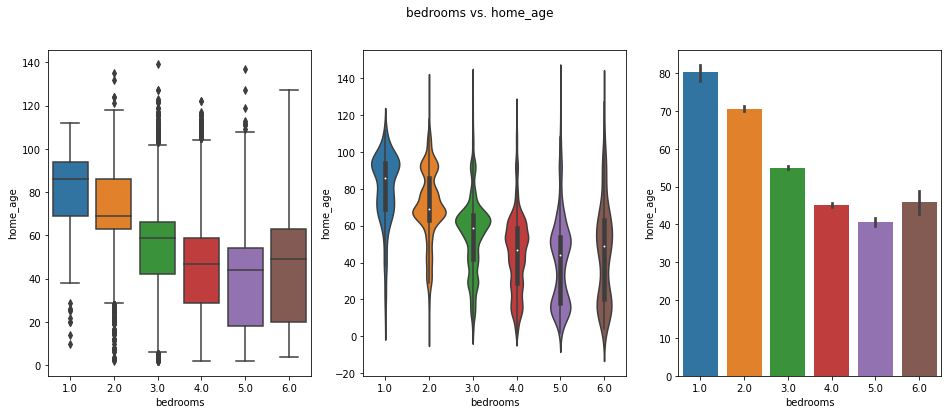

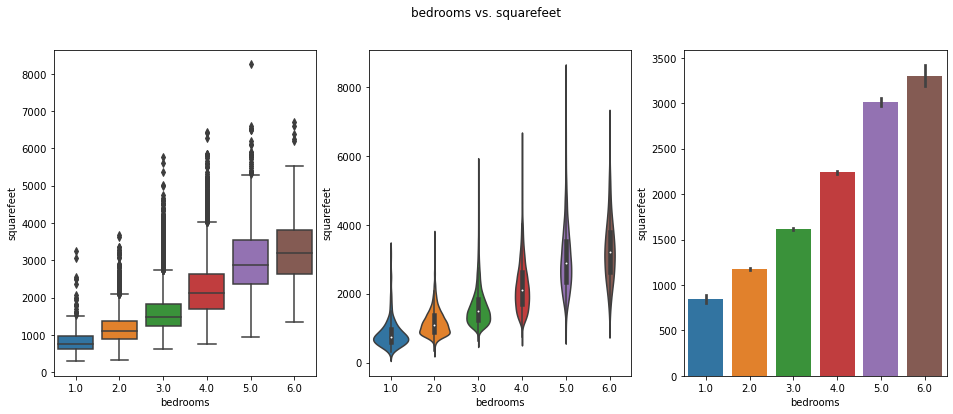

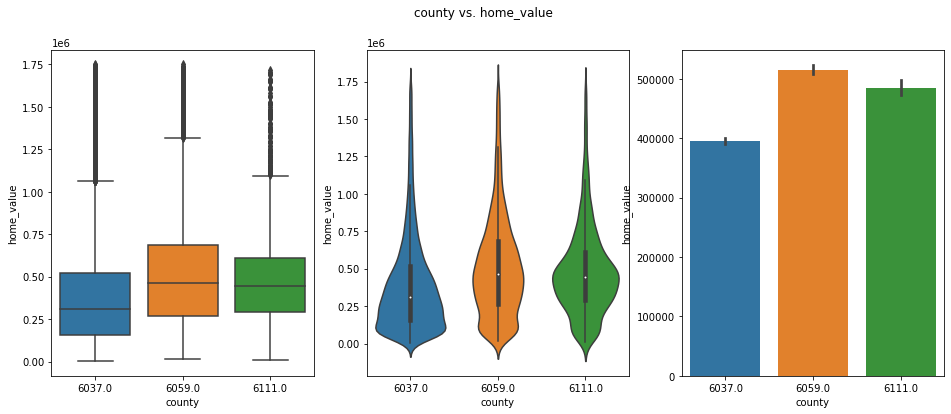

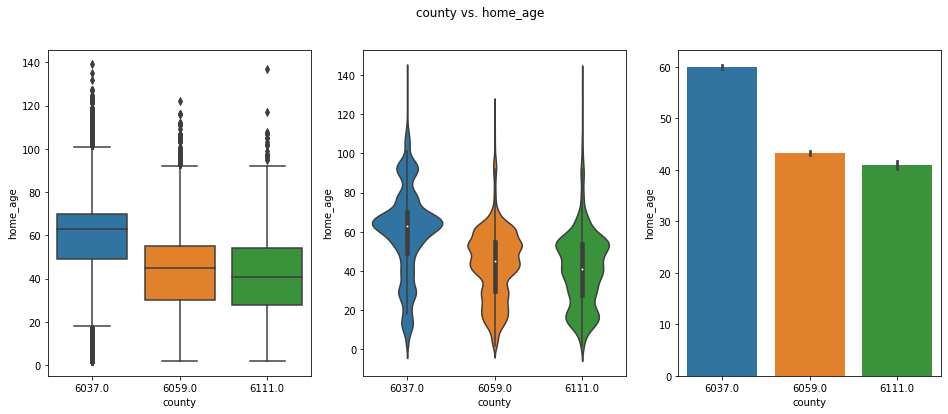

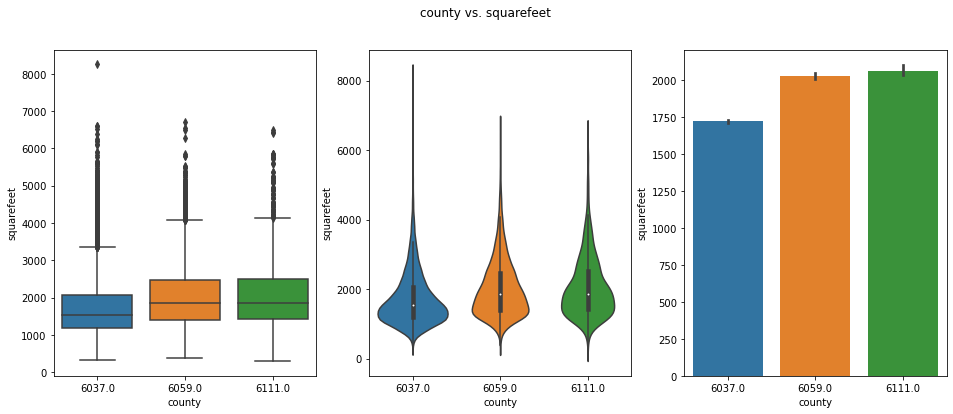

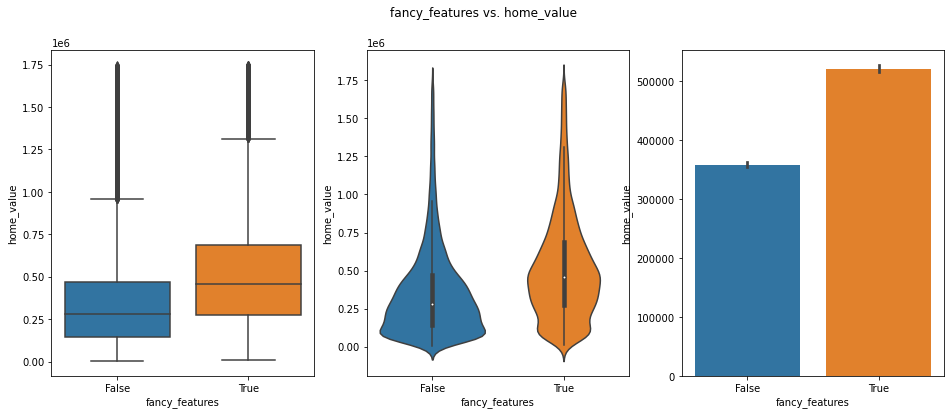

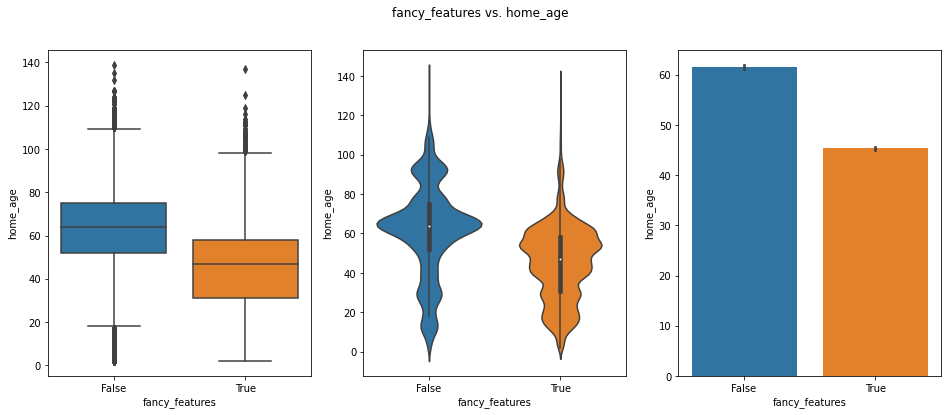

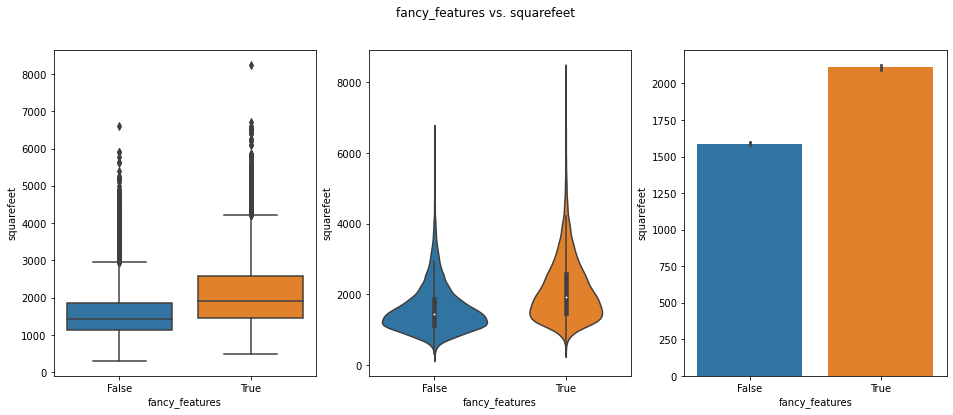

In [65]:
plot_categorical_and_continuous_vars(train, cat_vars, cont_vars)

<div class="alert alert-info">
Home_Value increases with features:
    
    * pool
    
    * garage
    
    * deck
    
    * fireplace
    
    * Square feet
    
    * bathrooms
    
    * Bedrooms
    
    * fancy_feature

Questions:
       * Answer the following initial question
       
        * What does the average home look like
        
        * Do popular builts have a higher home value than the average built.
        
        * Do properties with more bathrooms have a higher home value? bedrooms? squarefeet?
        
        * What are the average attributes of home whose value that are in the bottom quantile?
        
        * Are one stories home more valuable than two story homes.
        
        * Does having things like pool, deck, fireplace, garage increase home value?
        
        *( maybe look into roomcnt, regionidcounty, propertycountylandusecode, regionzip,fullbathcnt, yearbuilt, calculatedbathbr)

# What does the average home look like?

In [66]:
columns = train.columns.to_list()

In [67]:
for i in columns:
    mean = train[i].mean()
    print (f'{i} mean = {mean}')

squarefeet mean = 1832.2255761923363
bathrooms mean = 2.2285059838772683
bedrooms mean = 3.273482723108065
home_value mean = 435017.5760147733
yearbuilt mean = 1963.1187187044995
fireplace mean = 0.14137575908235378
deck mean = 0.006924961823928407
pool mean = 0.20402002912035228
garage mean = 0.34425938421108704
county mean = 6049.246031464186
home_age mean = 53.88128129550055
fancy_features mean = 0.47086189140239354


The average home_value is 433,444
The average home is 1835 **squarefeet**, has between 2 to 2.5 **bathrooms**, and 3 **bedrooms**.
About 1 in 3 homes have a **garage** on average
and 1 in 5 homes have a **pool** on average
1 in 7 have a **fireplace**
and less tha 1% have a **deck**


# What is the most popular built?

In [68]:
for i in columns:
    mode = train[i].mode()
    print (f'{i} mode = {mode}')

squarefeet mode = 0   1,120.000
Name: squarefeet, dtype: float64
bathrooms mode = 0   2.000
Name: bathrooms, dtype: float64
bedrooms mode = 0   3.000
Name: bedrooms, dtype: float64
home_value mode = 0   455,000.000
Name: home_value, dtype: float64
yearbuilt mode = 0   1,955.000
Name: yearbuilt, dtype: float64
fireplace mode = 0   0.000
Name: fireplace, dtype: float64
deck mode = 0   0.000
Name: deck, dtype: float64
pool mode = 0   0.000
Name: pool, dtype: float64
garage mode = 0   0.000
Name: garage, dtype: float64
county mode = 0   6,037.000
Name: county, dtype: float64
home_age mode = 0   62.000
Name: home_age, dtype: float64
fancy_features mode = 0    False
Name: fancy_features, dtype: bool


The most popular built is a home with 1_120 squarefeet, 2 bathrooms, 3 bedrooms,  

# Do popular builts have a higher home value than others? More house vs minimal house

In [69]:
house = train[ (train.bathrooms ==2)&(train.bedrooms ==3)]
house.shape

(7467, 12)

In [70]:
more_house = train[ (train.bathrooms>2)&(train.bedrooms >3)]

In [71]:
minimal_house = train[(train.bathrooms<2)&(train.bedrooms <3)]

In [72]:
more_house.home_value.median(), minimal_house.home_value.median(), house.home_value.median()

(579910.0, 238985.5, 305595.0)

In [73]:
more_house.home_value.mean(), minimal_house.home_value.mean(), house.home_value.mean()

(638697.385959844, 281079.0224719101, 346527.04687290743)

# Homes with the ideal amount of bathrooms?

In [74]:
train.bathrooms.median()

2.0

In [75]:
house = train[train.bathrooms == 2]
more_house = train[ train.bathrooms>2]

minimal_house = train[train.bathrooms<2]



In [76]:
more_house.home_value.median(), minimal_house.home_value.median(), house.home_value.median()

(553847.5, 238565.0, 310039.0)

In [77]:
more_house.home_value.mean(), minimal_house.home_value.mean(), house.home_value.mean()

(616681.9694493092, 278092.3001227855, 355172.2855500821)

#  What are the average attributes of home whose value that are in the bottom quantile?

In [78]:
bottom_q = train[train.home_value < train.home_value.quantile(.25)]

In [79]:
bottom_q.bedrooms.mean(), bottom_q.bathrooms.median()

(3.0446022727272726, 2.0)

In [80]:
bottom_q.bathrooms.mean(), bottom_q.bathrooms.median()

(1.8395596590909091, 2.0)

In [81]:
bottom_q.home_value.mean()

103369.86022727273

In [82]:
def show_cat_vs_cont(df, cat_vars=cat_vars, cont_vars=cont_vars):
    print('Categorical vs Continuous Variables:')
    #number = 1
    palettes = ['flare', 'Blues_r', 'PuRd_r', 'Accent']
    for j, cont in enumerate(cont_vars):
        plt.figure(figsize=(20,4))
        plt.suptitle(cont)
        for i, cat in enumerate(cat_vars):
            plt.subplot(1, 4, i+1)
            sns.barplot(data=df, x=cat, y=cont, palette=palettes[j])
            plt.title(cat + ' vs ' + cont)
        plt.show()

In [83]:
# show_cat_vs_cont(train, cat_vars,cont_vars)

# Does having an extra feature in a home raise home value?

In [84]:
#train['fancy_features'] = (train.garage==1)|(train.deck == 1)|(train.pool == 1)|(train.fireplace == 1)

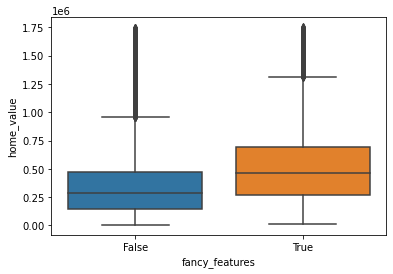

In [85]:
sns.boxplot(data=train, x='fancy_features', y='home_value');

# Is fips a driver of home value?

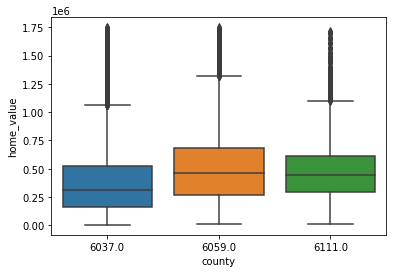

In [86]:
sns.boxplot(data=train, x='county', y='home_value');

In [87]:
train.head()

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,county,home_age,fancy_features
32899,"1,026.000",1.000,2.000,"346,258.000","1,924.000",0.000,0.000,0.000,0.000,"6,037.000",93.000,False
4511,"1,728.000",2.000,3.000,"520,000.000","1,987.000",0.000,0.000,0.000,0.000,"6,037.000",30.000,False
29470,"1,840.000",2.000,4.000,"217,589.000","1,973.000",0.000,0.000,0.000,1.000,"6,059.000",44.000,True
15398,"2,581.000",3.000,4.000,"210,507.000","1,994.000",0.000,0.000,1.000,0.000,"6,037.000",23.000,True
14156,902.000,2.000,2.000,"294,263.000","1,950.000",0.000,0.000,0.000,0.000,"6,037.000",67.000,False


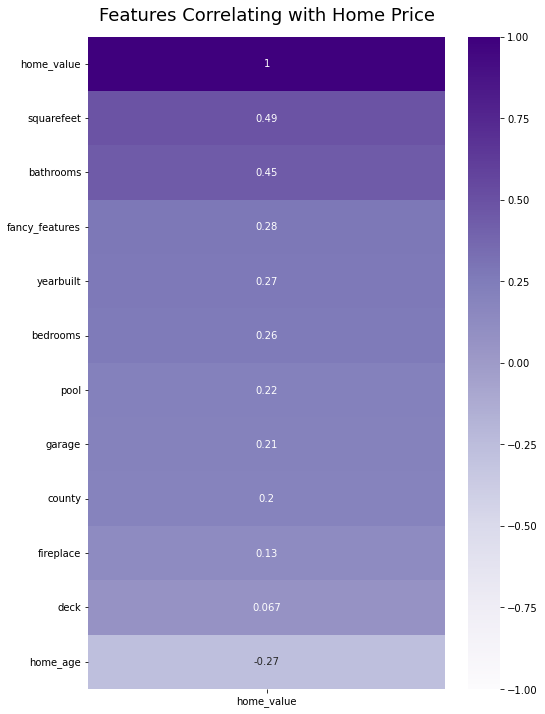

In [88]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr(method='spearman')[['home_value']].sort_values(by='home_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Purples')
heatmap.set_title('Features Correlating with Home Price', fontdict={'fontsize':18}, pad=16);

<div class="alert alert-info">Highest correlation seems to be squarefeet, bathrooms and fancy_features, yearbuilt

In [89]:
columns = train.columns.to_list()
columns

['squarefeet',
 'bathrooms',
 'bedrooms',
 'home_value',
 'yearbuilt',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'county',
 'home_age',
 'fancy_features']

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

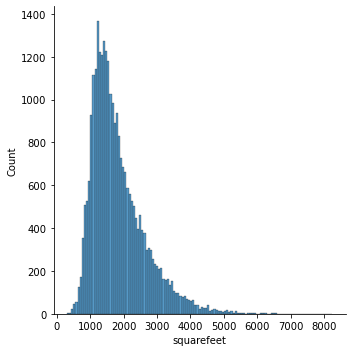

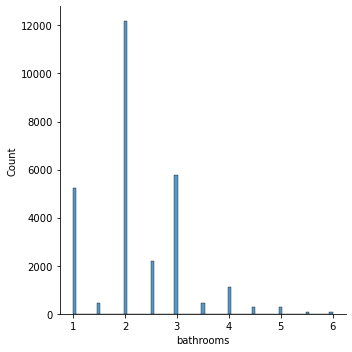

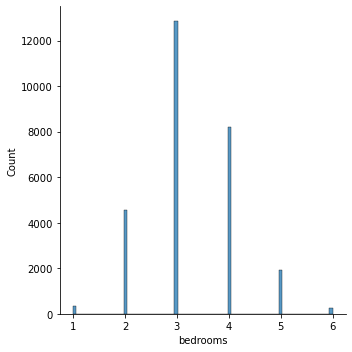

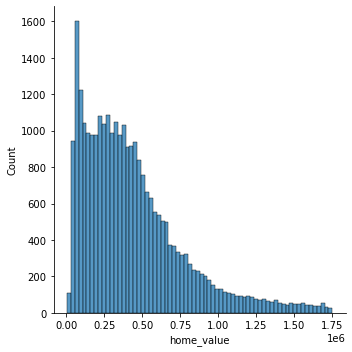

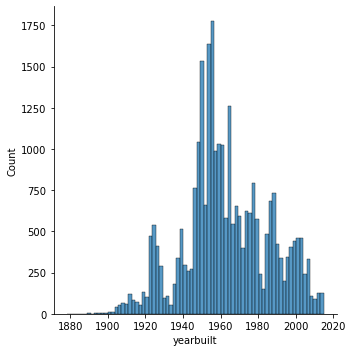

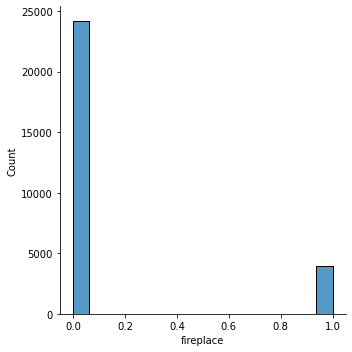

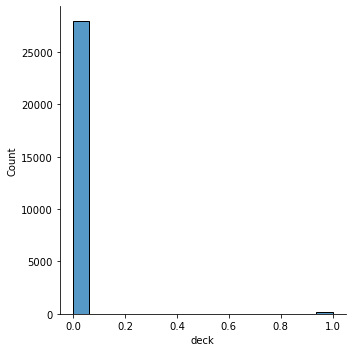

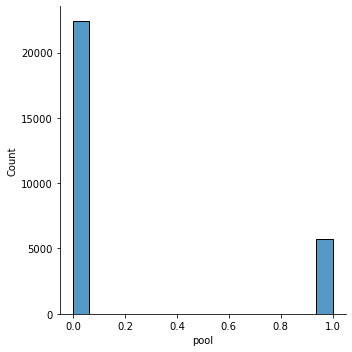

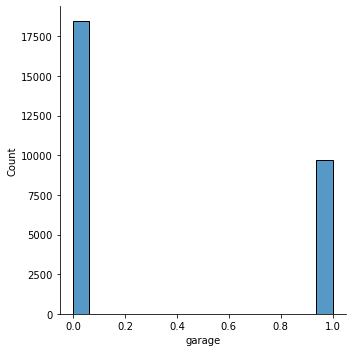

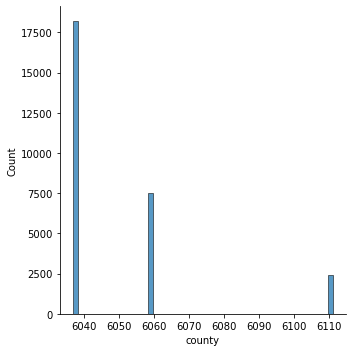

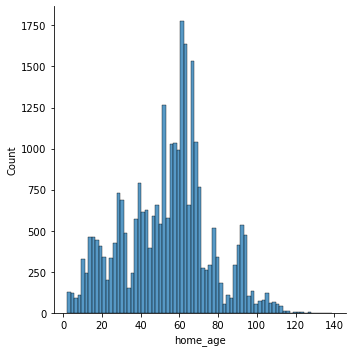

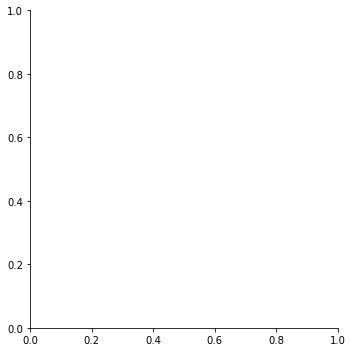

In [90]:
#for i in columns:    
 #   sns.displot(train[i])

# Stats

In [ ]:
above_mean_bathrooms = train.bathrooms[train.bathrooms > train.bathrooms.mean()]
overall_mean = train.bathrooms.mean()

In [ ]:
alpha=0.05
t, p = stats.ttest_1samp(above_mean_bathrooms, overall_mean)

print(t, p/2)

In [ ]:
# pearsonr r for continuous variables
for i in cont_vars:
    α =0.05
    corr, p = stats.pearsonr(train[i], train.tax_value)
    print('_____________________________________________________')
    print('HYPOTHESIS')
    print(f'H0: There is no significant difference between tax_value in different {i}')
    print(f'Ha:(There is a significant difference between tax_value in different {i}')
    print(f'{i} correlation {corr}, p-val{p}')
    if p < α:
        print('We reject the null hypothesis.')
        print(f'There is a correlation between tax_value and {i}')
    else:
        print('We fail to reject the null hypothesis.')
        print(f'There is no correlation between tax_value and {i}')

In [ ]:
for i in cat_vars:
    α =0.05
    corr, p = stats.pearsonr(train[i], train.tax_value)
    print('_____________________________________________________')
    print('HYPOTHESIS')
    print(f'H0: There is no significant difference between tax_value in different {i}')
    print(f'Ha:(There is a significant difference between tax_value in different {i}')
    print(f'{i} correlation {corr}, p-val{p}')
    if p < α:
        print('We reject the null hypothesis.')
        print(f'There is a correlation between tax_value and {i}')
    else:
        print('We fail to reject the null hypothesis.')
        print(f'There is no correlation between tax_value and {i}')

# Model

In [91]:
columns.remove('home_value')

In [92]:
columns

['squarefeet',
 'bathrooms',
 'bedrooms',
 'yearbuilt',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'county',
 'home_age',
 'fancy_features']

In [93]:
# Relabeling FIPS data
train['county'] = train.county.replace({6037:'Los Angeles',
                       6059:'Orange',
                       6111:'Ventura'})
# Creating Dummy Variables from County
train = pd.get_dummies(train, columns=['county','fancy_features'], drop_first=False)

In [94]:
# Relabeling FIPS data
validate['county'] = validate.county.replace({6037:'Los Angeles',
                       6059:'Orange',
                       6111:'Ventura'})
# Creating Dummy Variables from County
validate = pd.get_dummies(validate, columns=['county','fancy_features'], drop_first=False)

In [95]:
# Relabeling FIPS data
test['county'] = test.county.replace({6037:'Los Angeles',
                       6059:'Orange',
                       6111:'Ventura'})
# Creating Dummy Variables from County
test= pd.get_dummies(test, columns=['county','fancy_features'], drop_first=False)

In [96]:
train.shape

(28159, 15)

In [97]:
validate.shape

(12069, 15)

In [98]:
validate.columns

Index(['squarefeet', 'bathrooms', 'bedrooms', 'home_value', 'yearbuilt',
       'fireplace', 'deck', 'pool', 'garage', 'home_age', 'county_Los Angeles',
       'county_Orange', 'county_Ventura', 'fancy_features_False',
       'fancy_features_True'],
      dtype='object')

In [99]:
test.shape

(10058, 15)

In [100]:
train.columns.to_list()

['squarefeet',
 'bathrooms',
 'bedrooms',
 'home_value',
 'yearbuilt',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'home_age',
 'county_Los Angeles',
 'county_Orange',
 'county_Ventura',
 'fancy_features_False',
 'fancy_features_True']

# VIF

In [195]:
X = train[['squarefeet', 'home_age', 'county_Los Angeles',
        'fancy_features_True']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,squarefeet,5.494
1,home_age,5.220
2,county_Los Angeles,5.895
3,fancy_features_True,3.844


### Scale Data

In [102]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['squarefeet','bathrooms','bedrooms','yearbuilt','home_age']):
    '''
    scale_data takes in train , validate, test data  and returns their scaled counterparts.
    '''
    # create copies of our original data
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #create the scaler
    scaler = QuantileTransformer(output_distribution='normal')
    # fit the scaler into train data
    scaler.fit(train[columns_to_scale])
    
    # applying the scaler to train, validate, and test data
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    return train_scaled, validate_scaled, test_scaled

In [103]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(train,validate,test)

In [104]:
X_train_scaled

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,home_age,county_Los Angeles,county_Orange,county_Ventura,fancy_features_False,fancy_features_True
32899,-1.281,-5.199,-1.328,"346,258.000",-1.630,0.000,0.000,0.000,0.000,1.630,1,0,0,1,0
4511,0.130,-0.205,-0.250,"520,000.000",0.922,0.000,0.000,0.000,0.000,-0.922,1,0,0,1,0
29470,0.274,-0.205,0.758,"217,589.000",0.491,0.000,0.000,0.000,1.000,-0.491,0,1,0,0,1
15398,0.998,0.900,0.758,"210,507.000",1.200,0.000,0.000,1.000,0.000,-1.200,1,0,0,0,1
14156,-1.604,-0.205,-1.328,"294,263.000",-0.688,0.000,0.000,0.000,0.000,0.688,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23414,-0.315,0.900,-0.250,"73,891.000",0.451,0.000,0.000,0.000,0.000,-0.451,1,0,0,1,0
39632,0.763,0.900,1.706,"113,492.000",0.491,0.000,0.000,0.000,1.000,-0.491,0,1,0,0,1
47144,-0.073,-0.205,-1.328,"189,810.000",-0.383,0.000,0.000,0.000,0.000,0.383,1,0,0,1,0
45444,0.267,-0.205,-0.250,"299,124.000",-0.294,0.000,0.000,0.000,1.000,0.294,0,1,0,0,1


# Set up X and y target

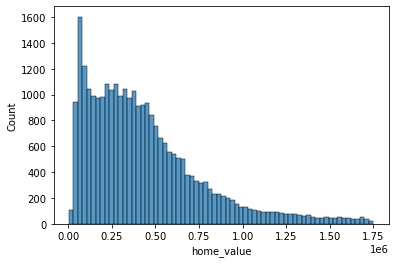

In [108]:
sns.histplot(y_train)

plt.show()

In [113]:
 columns_to_scale=['squarefeet','bathrooms','bedrooms','yearbuilt','home_age']

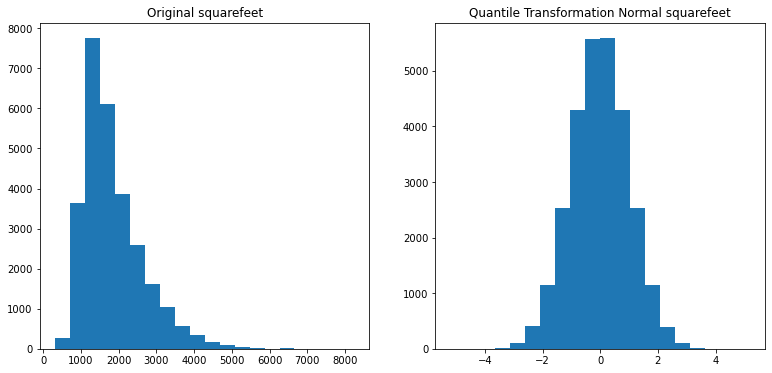

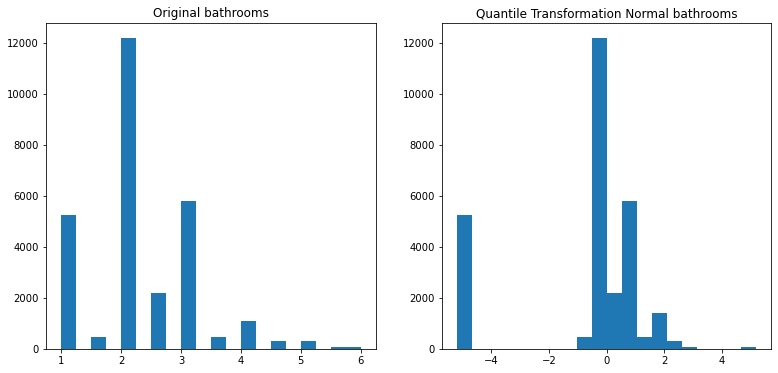

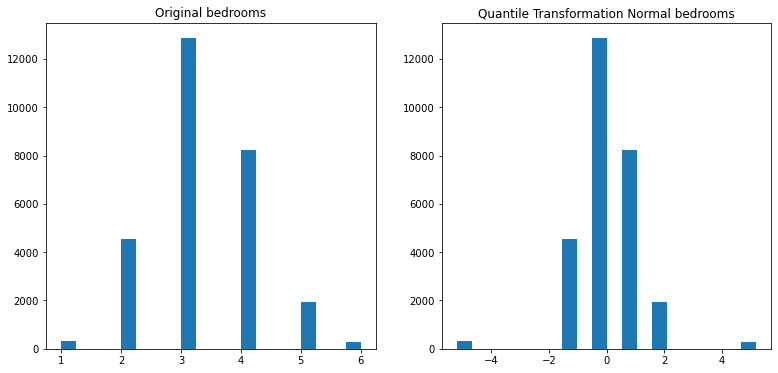

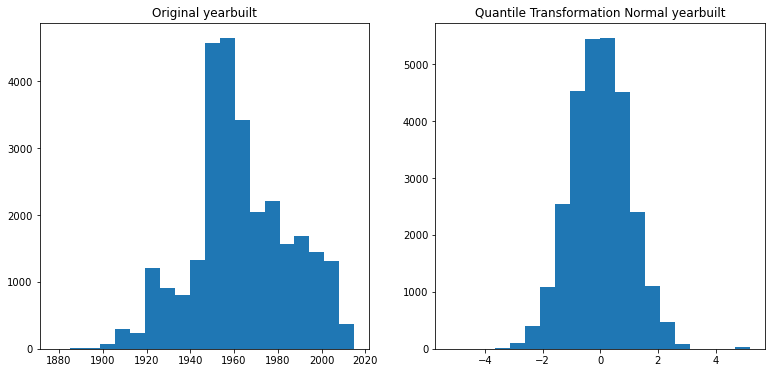

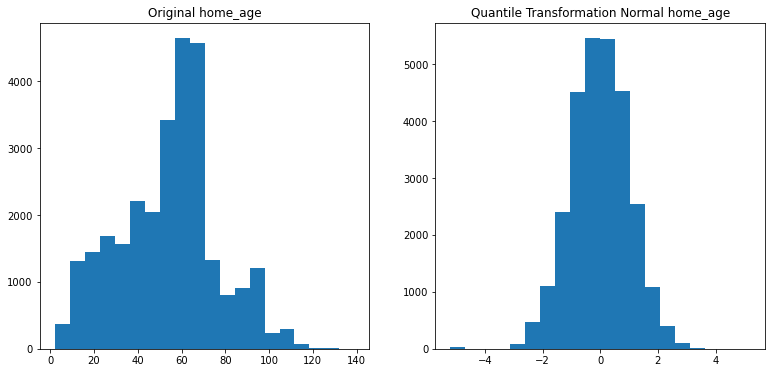

In [114]:
for i in columns_to_scale:
    plt.figure(figsize=(13, 6))
    plt.subplot(121)
    plt.hist(data=train, x= i,bins=20)
    plt.title(f'Original {i}')
    
    plt.subplot(122)
    plt.hist(x= i, data=X_train_scaled,bins=20)
    plt.title(f'Quantile Transformation Normal {i}')

    plt.show();

In [105]:
# Setup X and y
X_train_scaled = X_train_scaled.drop(columns='home_value')
y_train = train.home_value

X_validate_scaled = X_validate_scaled.drop(columns='home_value')
y_validate = validate.home_value

X_test_scaled = X_test_scaled.drop(columns='home_value')
y_test = test.home_value

In [117]:
X_test_scaled.dtypes

squarefeet              float64
bathrooms               float64
bedrooms                float64
yearbuilt               float64
fireplace               float64
deck                    float64
pool                    float64
garage                  float64
home_age                float64
county_Los Angeles        uint8
county_Orange             uint8
county_Ventura            uint8
fancy_features_False      uint8
fancy_features_True       uint8
dtype: object

# Baseline

In [126]:
from sklearn.metrics import mean_squared_error
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict HV_pred_mean
HV_pred_mean = y_train.home_value.mean()
y_train['HV_pred_mean'] = HV_pred_mean
y_validate['HV_pred_mean'] = HV_pred_mean

# 2. compute G3_pred_median
HV_pred_median = y_train.home_value.median()
y_train['HV_pred_median'] = HV_pred_median
y_validate['HV_pred_median'] = HV_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.home_value, y_train.HV_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.HV_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.home_value, y_train.HV_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.HV_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  332860.03 
Validate/Out-of-Sample:  327419.87
RMSE using Median
Train/In-Sample:  340572.16 
Validate/Out-of-Sample:  333213.18


In [159]:
y_train

,home_value,HV_pred_mean,HV_pred_median,HV_pred_lm
32899,"346,258.000","435,017.576","362,951.000","248,320.000"
4511,"520,000.000","435,017.576","362,951.000","423,424.000"
29470,"217,589.000","435,017.576","362,951.000","495,616.000"
15398,"210,507.000","435,017.576","362,951.000","605,696.000"
14156,"294,263.000","435,017.576","362,951.000","131,584.000"
...,...,...,...,...
23414,"73,891.000","435,017.576","362,951.000","330,752.000"
39632,"113,492.000","435,017.576","362,951.000","552,448.000"
47144,"189,810.000","435,017.576","362,951.000","444,928.000"
45444,"299,124.000","435,017.576","362,951.000","546,816.000"


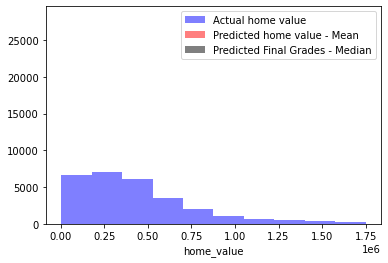

In [149]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.home_value, color='blue', alpha=.5, label='Actual home value')
plt.hist(y_train.HV_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted home value - Mean")
plt.hist(y_train.HV_pred_median, bins=1, color='black', alpha=.5, rwidth=100, label="Predicted Final Grades - Median")
plt.xlabel("home_value")

plt.legend()
plt.show()

# OLS Model

In [153]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['HV_pred_lm'] = lm.predict(X_train_scaled)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [157]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.HV_pred_lm)**(1/2)
# predict validate
y_validate['HV_pred_lm'] = lm.predict(X_validate_scaled)

In [158]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.HV_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  280034.4826456796 
Validation/Out-of-Sample:  276086.29032129166


# Lasso Lars

In [161]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['HV_pred_lars'] = lars.predict(X_train_scaled)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:652: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=7.747e+01, with an active set of 5 regressors, and t

In [162]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.HV_pred_lars)**(1/2)

# predict validate
y_validate['HV_pred_lars'] = lars.predict(X_validate_scaled)

In [163]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.HV_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  280337.9709551959 
Validation/Out-of-Sample:  276477.1918957588


# TweedieRegressor (GLM)

In [167]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.home_value)

# predict train
y_train['HV_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.HV_pred_glm)**(1/2)

# predict validate
y_validate['HV_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.HV_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  272993.0291824847 
Validation/Out-of-Sample:  268138.7534323619


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


# Polynomial Regression

In [168]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [169]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.home_value)

# predict train
y_train['HV_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.HV_pred_lm2)**(1/2)

# predict validate
y_validate['HV_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.HV_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  264401.4366253138 
Validation/Out-of-Sample:  257578.08174396536


,home_value,HV_pred_mean,HV_pred_median,G3_pred_lm,HV_pred_lm,HV_pred_lars,HV_pred_glm,HV_pred_lm2
39225,"389,492.000","435,017.576","362,951.000","259,584.000","259,584.000","263,216.765","278,029.929","263,040.000"
15407,"318,000.000","435,017.576","362,951.000","557,568.000","557,568.000","551,991.675","526,665.204","491,776.000"
37785,"248,333.000","435,017.576","362,951.000","433,152.000","433,152.000","429,368.155","405,975.948","337,792.000"
30638,"457,701.000","435,017.576","362,951.000","536,064.000","536,064.000","537,797.460","506,366.987","505,568.000"
30573,"369,895.000","435,017.576","362,951.000","512,000.000","512,000.000","531,108.168","504,666.026","553,792.000"
...,...,...,...,...,...,...,...,...
26970,"465,000.000","435,017.576","362,951.000","352,256.000","352,256.000","354,469.644","338,483.874","315,584.000"
18965,"467,781.000","435,017.576","362,951.000","519,168.000","519,168.000","514,209.185","490,778.538","529,536.000"
2798,"193,418.000","435,017.576","362,951.000","403,456.000","403,456.000","405,354.530","372,750.488","290,912.000"
10674,"76,597.000","435,017.576","362,951.000","386,560.000","386,560.000","376,131.756","331,447.149","358,272.000"


# Evaluate

In [237]:
def calculate_mse(y_predicted):
    return mean_squared_error(y_train.home_value, y_predicted)



pd.options.display.float_format = '{:,.3f}'.format

def calculate_RMSE(y_predicted):
    return mean_squared_error(y_train.home_value,y_predicted)**.5


In [238]:
y_train.apply(calculate_mse).sort_values()

home_value                     0.000
HV_pred_lm3       66,298,119,161.570
HV_pred_lm2       69,908,119,689.530
HV_pred_glm       74,525,193,982.229
HV_pred_lm        78,419,311,470.633
HV_pred_lars      78,589,377,959.276
multiple_rfe     100,867,721,501.811
HV_pred_mean     110,795,802,062.781
HV_pred_median   115,989,393,441.274
dtype: float64

In [239]:
y_train.apply(calculate_RMSE).sort_values()

home_value             0.000
HV_pred_lm3      257,484.211
HV_pred_lm2      264,401.437
HV_pred_glm      272,993.029
HV_pred_lm       280,034.483
HV_pred_lars     280,337.971
multiple_rfe     317,596.791
HV_pred_mean     332,860.034
HV_pred_median   340,572.156
dtype: float64

BEST MODELS are  LM2 and then GLM then LM:

HV_pred_lm2      264,401.437

HV_pred_glm      272,993.029

HV_pred_lm       280,034.483


In [243]:
y_validate

,home_value,HV_pred_mean,HV_pred_median,G3_pred_lm,HV_pred_lm,HV_pred_lars,HV_pred_glm,HV_pred_lm2,HV_pred_lm3
39225,"389,492.000","435,017.576","362,951.000","259,584.000","259,584.000","263,216.765","278,029.929","263,040.000","260,352.000"
15407,"318,000.000","435,017.576","362,951.000","557,568.000","557,568.000","551,991.675","526,665.204","491,776.000","458,048.000"
37785,"248,333.000","435,017.576","362,951.000","433,152.000","433,152.000","429,368.155","405,975.948","337,792.000","324,928.000"
30638,"457,701.000","435,017.576","362,951.000","536,064.000","536,064.000","537,797.460","506,366.987","505,568.000","496,448.000"
30573,"369,895.000","435,017.576","362,951.000","512,000.000","512,000.000","531,108.168","504,666.026","553,792.000","557,376.000"
...,...,...,...,...,...,...,...,...,...
26970,"465,000.000","435,017.576","362,951.000","352,256.000","352,256.000","354,469.644","338,483.874","315,584.000","310,976.000"
18965,"467,781.000","435,017.576","362,951.000","519,168.000","519,168.000","514,209.185","490,778.538","529,536.000","525,760.000"
2798,"193,418.000","435,017.576","362,951.000","403,456.000","403,456.000","405,354.530","372,750.488","290,912.000","279,168.000"
10674,"76,597.000","435,017.576","362,951.000","386,560.000","386,560.000","376,131.756","331,447.149","358,272.000","416,192.000"


In [247]:
calculate_RMSE(y_validate)

ValueError: Found input variables with inconsistent numbers of samples: [28159, 12069]

# ADD MORE Models

In [235]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=4)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled)
X_test_degree3 = pf.transform(X_test_scaled)

In [236]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.home_value)

# predict train
y_train['HV_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.home_value, y_train.HV_pred_lm3)**(1/2)

# predict validate
y_validate['HV_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.home_value, y_validate.HV_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  257484.21148018027 
Validation/Out-of-Sample:  4.59869804737039e+16


# Multiple Regression + RFE 6 features

In [208]:
lm3 = LinearRegression()


# 1. Transform our X
rfe = RFE(lm, n_features_to_select=6)
rfe.fit(X_train_scaled, y_train.home_value)
print('selected top 6 features:', X_train_scaled.columns[rfe.support_])


selected top 6 features: Index(['home_age', 'county_Los Angeles', 'county_Orange', 'county_Ventura',
       'fancy_features_False', 'fancy_features_True'],
      dtype='object')


In [210]:
X_train_rfe = rfe.transform(X_train_scaled)
# 2. Use the transformed x in our model
lm3.fit(X_train_rfe, y_train.home_value)


LinearRegression()

In [220]:
X_train_scaled.shape

(28159, 14)

In [221]:
X_validate_rfe.shape

(12069, 6)

In [217]:
# 3. Make predictions

y_train['multiple_rfe'] = lm3.predict(X_train_rfe)

X_validate_rfe = rfe.transform(X_validate_scaled)


In [218]:
y_validate['multiple_rfe'] = lm.predict(X_validate_rfe)

ValueError: Expected a 1D array, got an array with shape (12069, 7)

In [204]:
X_train_scaled

,squarefeet,bathrooms,bedrooms,yearbuilt,fireplace,deck,pool,garage,home_age,county_Los Angeles,county_Orange,county_Ventura,fancy_features_False,fancy_features_True
32899,-1.281,-5.199,-1.328,-1.630,0.000,0.000,0.000,0.000,1.630,1,0,0,1,0
4511,0.130,-0.205,-0.250,0.922,0.000,0.000,0.000,0.000,-0.922,1,0,0,1,0
29470,0.274,-0.205,0.758,0.491,0.000,0.000,0.000,1.000,-0.491,0,1,0,0,1
15398,0.998,0.900,0.758,1.200,0.000,0.000,1.000,0.000,-1.200,1,0,0,0,1
14156,-1.604,-0.205,-1.328,-0.688,0.000,0.000,0.000,0.000,0.688,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23414,-0.315,0.900,-0.250,0.451,0.000,0.000,0.000,0.000,-0.451,1,0,0,1,0
39632,0.763,0.900,1.706,0.491,0.000,0.000,0.000,1.000,-0.491,0,1,0,0,1
47144,-0.073,-0.205,-1.328,-0.383,0.000,0.000,0.000,0.000,0.383,1,0,0,1,0
45444,0.267,-0.205,-0.250,-0.294,0.000,0.000,0.000,1.000,0.294,0,1,0,0,1


### Select Features for model

In [227]:
def select_Kbest(X, y, k=2):   
    '''
    select_Kbest takes in :
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of features
    
    returns: a list of the selected features using SelectBest 
    '''
    # model
    kbest = SelectKBest(f_regression, k=k)
    # fit
    kbest.fit(X, y)
    # mask of selection
    feature_mask = kbest.get_support()
    rank = X.columns[feature_mask]
    
    # convert to list
    rank = rank.to_list()


    return f'TOP {k} features: {rank}'

In [232]:
select_Kbest(X_train_scaled,y_train.home_value, k=5)

"TOP 5 features: ['squarefeet', 'bathrooms', 'bedrooms', 'fancy_features_False', 'fancy_features_True']"

### Simple model

In [ ]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
}) 

In [ ]:
# X must be 2-d array
#X_train_scaled = X_train_scaled[['bathrooms']]
# y can be 1-d array
#y_train = train.tax_value

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train_scaled[['bathrooms']], y_train)
# 3. use the thing (make predictions)
#X_validate = validate[['taxamount']]
predictions['simple_lm'] = lm.predict(X_validate[['bathrooms']])

In [ ]:
# look into modesl make up 
lm.coef_, lm.intercept_

In [ ]:
print(f'tax_value = {lm.coef_}*bathrooms + {lm.intercept_}')

In [ ]:
predictions

### Multiple + RFE

In [ ]:
def rfe(X, y, k=2):
    ''' 
    rfe takes in:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of features
    
    returns: a list of the selected features using RFE
    '''
    # Model
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select= k)
    #fit
    rfe.fit(X, y)
    # mask selection
    mask = rfe.get_support()
    
    return X.columns[mask]

In [ ]:
rfe(X_train_scaled, y_train, k=2)

In [222]:


lm = LinearRegression()
k = 2

### 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)
print('selected top 2 features:', X_train_scaled.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train_scaled)

selected top 2 features: Index(['yearbuilt', 'home_age'], dtype='object')


In [ ]:
# 1. Transform our X
X_train_rfe = rfe.transform(X_train_scaled)
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

In [ ]:
# look into models make up
lm.coef_, lm.intercept_

In [ ]:
print(f'tax_value = {lm.coef_[0]:.2f} x squarefeet + {lm.coef_[1]:.2f} x bedroom + {lm.intercept_:.2f}')

### Poly Degree2

In [ ]:
# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train_scaled)
X_train_poly = pd.DataFrame(
    poly.transform(X_train_scaled),
    columns=poly.get_feature_names(X_train_scaled.columns),
    index=train.index,
)
X_train_poly.head()

In [ ]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate_scaled)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)
predictions

# Poly interactions_only 

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train_scaled)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate_scaled)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train_scaled.columns)).sort_values()

In [ ]:
predictions

## Laso Lars

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

In [ ]:
predictions

# GLM

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train_scaled, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate_scaled)

# Add lassolars predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

### Baseline

In [ ]:
# add a baseline model
predictions['baseline'] = train.tax_value.mean()

In [ ]:
predictions

# Evaluate

In [ ]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
def calculate_RMSE(y_predicted):
    return mean_squared_error(predictions.acual,y_predicted)
predictions.apply(calculate_mse).sort_values()**.5

First itteration of models Polynomial degree2 was best, Then glm, then lasso_lars then baseline